## Project Setup

In [31]:
%%writefile requirements.txt

torch
torchvision
matplotlib
numpy
tqdm
pandas
opencv-python #cv2
albumentations
python-magic
torchmetrics
librosa
seaborn

Overwriting requirements.txt


## Imports

In [32]:
import os
import csv
import tqdm
import torch
import torchaudio
import numpy as np
import torchvision
import torchmetrics
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from misc.constants import CONST
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Project functions

In [3]:
def collect_file_names_and_labels(data_path: str):
    file_names = []
    labels = [] 
    for root, _, files in os.walk(data_path):
        for file in files:
            base_name, _ = os.path.splitext(file)
            full_path = os.path.join(data_path, file)
            file_names.append(full_path)
            labels.append(int(base_name.rsplit('_', 1)[-1]))
    return file_names, labels

def create_label_table(data_path: str, csv_path: str):
    file_names, labels = collect_file_names_and_labels(data_path)
    assert len(file_names) == len(labels), "file_paths and labels lists must have the same length"

    with open(csv_path, mode='w+', newline='', encoding='utf-8') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['file_path', 'label'])
        for file_name, label in zip(file_names, labels):
            writer.writerow([file_name, label])

In [4]:
def pad_collate(batch):
    data, labels = zip(*batch)    
    max_length = max(x.shape[1] for x in data)  
    padded_data = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in data] 
    
    data_tensor = torch.stack(padded_data)
    labels_tensor = torch.tensor(labels)
    
    return data_tensor, labels_tensor

In [5]:
class PadCollate:
    def __init__(self, dim=2, pad_value=0):
        """
        dim - the dimension to be padded (default is 2 for time series padding)
        pad_value - the value used for padding shorter sequences
        """
        self.dim = dim
        self.pad_value = pad_value

    def pad_collate(self, batch):
        # Extract data (xs) and targets (ys) from batch
        xs, ys = zip(*batch)
        # Convert xs to tensors if necessary (assumes xs are already tensors)
        xs = [x.squeeze(0).transpose(0, 1) for x in xs]  # Adjust shape if necessary
        # Pad all sequences to the length of the longest sequence
        xs_padded = pad_sequence(xs, batch_first=True, padding_value=self.pad_value)
        ys = torch.tensor(ys)
        return xs_padded, ys

    def __call__(self, batch):
        return self.pad_collate(batch)
    
def pad_collate(batch):
    data, labels = zip(*batch)    
    max_length = max(x.shape[1] for x in data)  
    padded_data = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in data] 
    
    data_tensor = torch.stack(padded_data)
    labels_tensor = torch.tensor(labels)
    
    return data_tensor, labels_tensor

In [6]:
create_label_table("dataset", CONST.CSV_PATH)

In [7]:
df = pd.read_csv(CONST.CSV_PATH)
df.head()

,file_path,label
0,dataset/augmented_augmented_augmented_augmente...,6
1,dataset/augmented_augmented_woman_28_02.mp3,2
2,dataset/augmented_augmented_woman_16_04.mp3,4
3,dataset/augmented_augmented_woman_50_08.mp3,8
4,dataset/augmented_augmented_woman_31_03.mp3,3


## Dataset

In [8]:
class AudioDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transforms=True):
        self.data = data
        self.transforms = transforms
        self.sr = 16000
        self.n_fft = 2048
        self.hop_length = 512
        self.n_filter = 40
        self.n_lfcc = 13

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        path = item['file_path']
        audio, sr = torchaudio.load(path)
        audio = torchaudio.transforms.LFCC(sample_rate=self.sr, 
                                                n_filter=self.n_filter,
                                                n_lfcc=self.n_lfcc)(audio)
        label = torch.tensor(item['label']).long()
        return audio, label


## Split data

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
params = {
    "epochs": 50,
    "lr": 0.001,
    "batch_size": 32,
    "device": device,
    "classes": 10,
}

In [11]:
train_df, valid_df = train_test_split(df, train_size=0.8)
train_dataset, validation_dataset = AudioDataset(train_df), AudioDataset(valid_df)

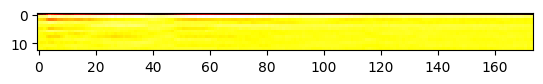

torch.Size([1, 13, 174])

In [12]:
audio, label = train_dataset[150]
lfcc_features = audio[0].squeeze() 
plt.imshow(lfcc_features.numpy(), cmap='hot', interpolation='nearest')
plt.show()
audio.shape

In [13]:
valid_loader = DataLoader(validation_dataset, batch_size=params['batch_size'], collate_fn=PadCollate(dim=2))
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], collate_fn=PadCollate(dim=2))

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Ensure there's a channel dimension
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [15]:
def setup_metrics(device, num_classes):
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    prec = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
    recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
    return acc, prec, recall, f1


In [16]:
train_loss = []
val_loss = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [17]:
model = CNN(10).to(params['device'])
criterion = nn.BCEWithLogitsLoss().to(params['device'])
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

  0%|          | 0/1 [00:00<?, ?it/s]

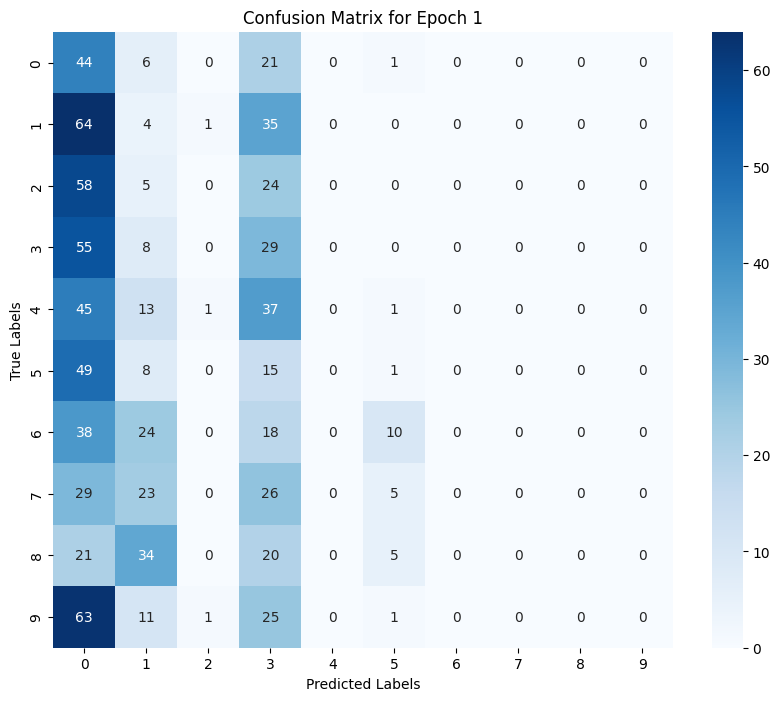

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [39]:
for epoch in tqdm.trange(1):
    # model.train()
    total_val_loss = 0
    total_train_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss.append(total_train_loss / len(train_loader))

    model.eval()
    acc, prec, recall, f1 = setup_metrics(device, 10)
    all_targets, all_preds = [], []

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            acc(output, target)
            prec(output, target)
            recall(output, target)
            f1(output, target)
            total_val_loss += loss.item()

            # Store predictions and targets for confusion matrix
            _, predicted_labels = torch.max(output, 1)
            all_preds.extend(predicted_labels.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

        accuracies.append(acc.compute())
        precisions.append(prec.compute())
        recalls.append(recall.compute())
        f1_scores.append(f1.compute())
        val_loss.append(total_val_loss / len(valid_loader))

        # Compute confusion matrix
        cm = confusion_matrix(all_targets, all_preds, labels=np.arange(10))

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix for Epoch {}'.format(epoch + 1))
        plt.show()

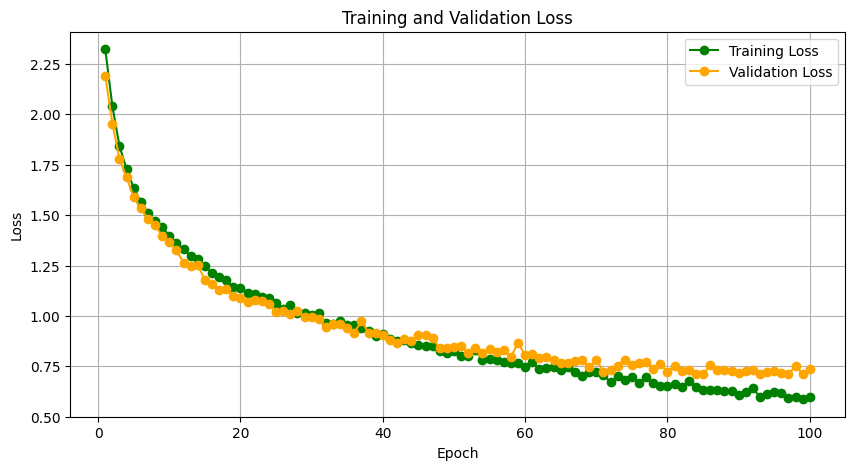

In [21]:
# Adding epoch numbers as labels for the x-axis
epochs = list(range(1, 101))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color="green")
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color="orange")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.xticks(epochs)

plt.grid(True)
plt.show()

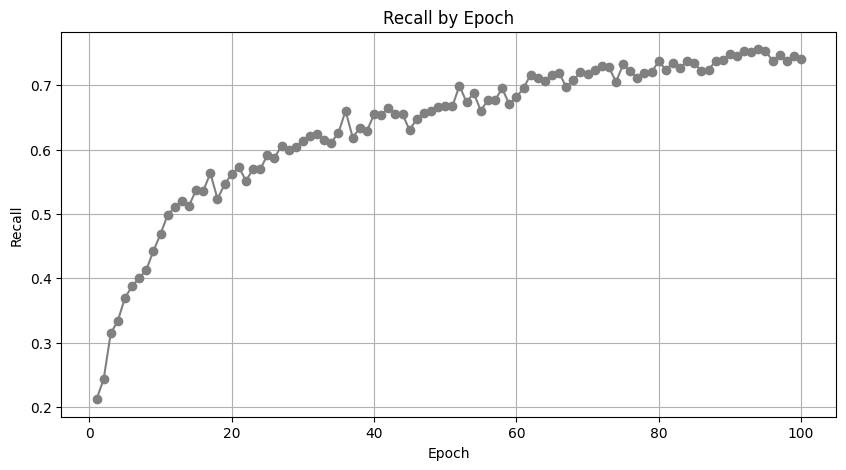

In [29]:
accuracies_t = [float(x.cpu()) for x in accuracies] 
f1_t = [float(x.cpu()) for x in f1_scores]
precisions_t = [float(x.cpu()) for x in precisions]
recalls_t = [float(x.cpu()) for x in recalls]
plt.figure(figsize=(10, 5))
plt.plot(epochs, recalls_t, marker='o', linestyle='-', color='gray')
plt.title('Recall by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

In [38]:
torch.save(model, "model6.pth")
model = torch.load("model.pth")
model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)